# C1.1: Comparison to numerical solutions

We compare the solutions of the different numerical codes that implemented 
the benchmarking problem C1.1. 

* [Dumux](Single root water uptake - Dumux.ipynb)

In particular, we compare the shape and time of the water potential versus radius curve at the onset of stress. 
For an automatic comparison of the numerical results, save the results in a text file, each result consisting of two rows containing comma separated radial distance values [cm] in the first, and matric potential [cm] in the second. This is done for each soil and transpiration rate scenario (i.e. 3 (soils) * 2 (transpiration rate) results = 6 rows). The files need to be located in the folder /C1.1 Numerical results/.

In [33]:
import numpy as np
from scipy import optimize
from scipy import integrate
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from math import * 
import os
import ast

In [34]:
# Mualem - van Genuchten model, equations from van Genuchten, MT (1980)

# class containing the van genuchten parameters
class Parameters:
    def __init__(self, R, S, alpha, n, Ksat, l):
        self.theta_R = R
        self.theta_S = S        
        self.alpha = alpha # [1/cm]         
        self.n = n
        self.m = 1.-1./n
        self.Ksat = Ksat   
        self.l = l

# returns the volumetric water content at a given pressure head  according to the van genuchten model (Eqn 21)
def water_content(h, sp):
    return sp.theta_R + (sp.theta_S-sp.theta_R)/pow(1. + pow(sp.alpha*abs(h),sp.n),sp.m)

# returns pressure head at a given volumetric water content according to the van genuchten model
def pressure_head(theta, sp): 
    theta = min(theta,sp.theta_S) # saturated water conent is the maximum 
    return - pow( pow( (sp.theta_S - sp.theta_R)/(theta - sp.theta_R), (1./sp.m))-1., 1./sp.n) / sp.alpha

# returns the effective saturation according to the van genuchten model (dimensionless water content, Eqn 2)
def effective_saturation(h,sp):
    h = min(h,0) # pressure head is negative, zero the maximum
    theta = water_content(h,sp)
    se = (theta-sp.theta_R)/(sp.theta_S-sp.theta_R)
    return se

# returns the hydraulic conductivity according to the van genuchten model (Eqn 8)
def hydraulic_conductivity(h,sp):
    se = effective_saturation(h,sp) 
    K = sp.Ksat*(se**sp.l)*( (1. - pow(1. - pow(se, 1. / sp.m),sp.m)) ** 2 )
    return K 

# returns the specific moisture storage according to the van genuchten model
def specific_moisture_storage(h,sp):
    C = -sp.alpha*sp.n*np.sign(h)*(1. / sp.n - 1.) * pow(sp.alpha*abs(h), sp.n-1.) * (sp.theta_R-sp.theta_S) * pow(pow(sp.alpha*abs(h),sp.n) + 1., 1./sp.n-2.)
    return C

# returns the water diffusivity (Eqn 11)
def water_diffusivity(TH, theta_i, theta_sur, sp):
    theta = TH * (theta_i - theta_sur) + theta_sur
    Se = (theta - sp.theta_R) / (sp.theta_S - sp.theta_R)
    m = sp.m
    D = (1 - m) * sp.Ksat / (sp.alpha * m * (sp.theta_S - sp.theta_R)) * pow(Se, sp.l - 1. / m) * (pow(1 - pow(Se, 1. / m), -m) + pow(1 - pow(Se, 1 / m), m) - 2)
    return D

# returns the matric flux potential
def MFP(h,sp):
    K = lambda h: hydraulic_conductivity(h,sp) # integrand 
    MFP, err = integrate.quad(K,-15000, h)
    return MFP

# returns the matric potential from matric flux potential
def h(MFP_given,sp):
    MFP_root = lambda psi: MFP(psi,sp)-MFP_given
    h = optimize.brentq(MFP_root, -15000, 0)
    return h

In [35]:
#sand = Parameters(0.02, 0.46, 0.0144, 1.534, 15.42, -0.215) 
#loam = Parameters(0.01, 0.42, 0.0084, 1.441, 12.98, -1.497)
#clay = Parameters(0.01, 0.59, 0.0195, 1.109, 4.53, -5.901)
sand = Parameters(0.045, 0.43, 0.15, 3, 1000,0.5) 
loam = Parameters(0.08, 0.43, 0.04, 1.6, 50,0.5) 
clay = Parameters(0.1, 0.4, 0.01, 1.1, 10,0.5) 

[0, 0]
[1, 0]
[0, 1]
[1, 1]
[0, 2]
[1, 2]
Name		 N	 R²		 R
DuMux_c11.txt	 41 	 1.00000000 	 1.00000000
DuMux_c11.txt	 41 	 1.00000000 	 1.00000000
DuMux_c11.txt	 41 	 1.00000000 	 1.00000000
DuMux_c11.txt	 41 	 1.00000000 	 1.00000000
DuMux_c11.txt	 41 	 1.00000000 	 1.00000000
DuMux_c11.txt	 41 	 1.00000000 	 1.00000000


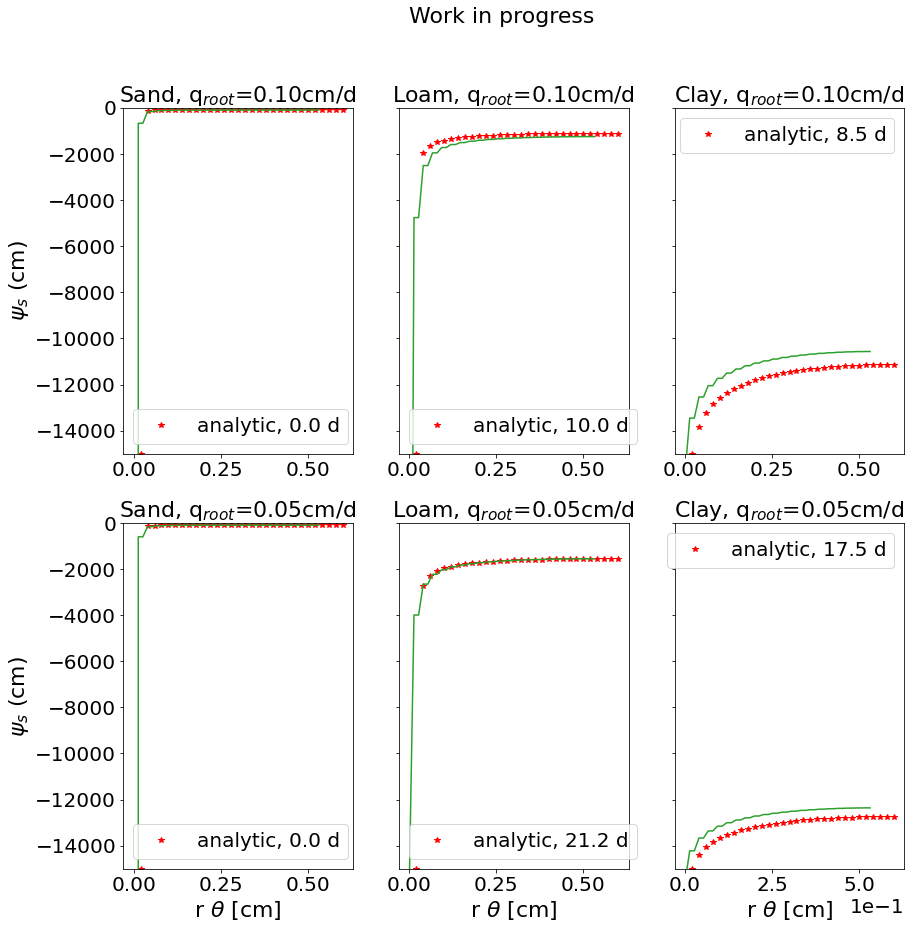

In [36]:
r_root = 0.02   # cm
r_out = 0.6        #cm
rho = r_out/r_root
h_out = np.linspace(-100,-14500,100);   #cm
h_lim = -15000   # cm
q_out = 0#q_root * (r_root/(2*r_out))
r = np.linspace(r_root, r_out, 30)
fig, ax = plt.subplots(2, 3,figsize=(14, 14))
h_stressonset = np.zeros((6,len(r))); wc_stressonset = np.zeros((6,len(r)));
ind=0; soils=["Sand", "Loam", "Clay"];
for s,soil in enumerate([sand, loam, clay]): 
    for q,q_root in enumerate([0.1,0.05]):    # q_root in [cm/d], high and low transpiration
        crit=0; k=0;
        while crit < 1:
            MFP_nostress = MFP(h_out[k],soil) + (q_root*r_root-q_out*r_out)*(r**2/r_root**2/(2*(1-rho**2))+rho**2/(1-rho**2)*(np.log(r_out/r)-0.5)) + q_out*r_out*np.log(r/r_out)
            if np.amin(MFP_nostress)<=0:   #stress   
                MFP_stress  = (MFP(h_out[k],soil)+q_out*r_out*np.log(1/rho))*( (r**2/r_root**2 - 1 + 2*rho**2*np.log(r_root/r))/(rho**2 - 1+2*rho**2*np.log(1/rho)) ) + q_out*r_out*np.log(r/r_root)
                for i in range(len(r)):        
                    h_stressonset[ind,i] = h(MFP_stress[i],soil) 
                    wc_stressonset[ind,i] = water_content(h_stressonset[ind,i],soil)
                crit=crit+1
                #print(crit)#(h_stressonset.shape)
            k=k+1;
        # plot
        Q = np.trapz(wc_stressonset[ind,:]*r,r)
        simtime=((r_out**2-r_root**2)*3.14*water_content(-100,soil) - Q*2*3.14)/(2*r_root*3.14*q_root)
        ax[int(q),int(s)].plot(r,h_stressonset[ind,:],'r*',label='analytic, '+"{:.1f}".format(simtime)+" d")
        ax[1,int(s)].set_xlabel("r (cm)")
        ax[int(q),0].set_ylabel("$\\psi_s$ (cm)")
        ax[int(q),1].set_yticklabels([]);ax[int(q),2].set_yticklabels([])
        ax[int(q),int(s)].set_ylim(-15000,0)
        ax[int(q),int(s)].legend() 
        ax[int(q),int(s)].title.set_text(soils[int(s)]+r', q$_{root}$='+"{:.2f}".format(q_root)+"cm/d")
        ind=ind+1;
# Numerical solutions
r, rsme, rsquare, nn, l = [], [], [], [], []
cc = 0
col=["C2","C0","b"]
for dirname, dirnames, filenames in os.walk('C1.1 Numerical results/.'):    
    filenames.sort()
    for i,f in enumerate(filenames):            
        try:        
            data = []
            with open('C1.1 Numerical results/'+f) as fp: 
                for line in fp:
                    s = ast.literal_eval("["+line+"]")                
                    data.append(s)    
            for k in range(0,3): # axis
                for j in range(0,2): 
                    print([j,k])
                    l.append(f)                    
                    r_n = data[2*(3*j+k)]
                    h_n = data[2*(3*j+k)+1]   
                    pl, = ax[j,k].plot(r_n,h_n,col[cc]) # numeric solution                        
                    interp = interp1d(np.linspace(r_root, r_out, 30),h_stressonset[3*j+k,:],  kind='linear', fill_value='extrapolate', bounds_error =False ) 
                    h_a = interp(sorted(h_n)) # analytical solution at points                    
                    # Evaluate
                    oi, pi = h_n, h_a
                    om, pm = np.mean(oi), np.mean(pi)
                    nn.append(len(oi))
                    # calculate R
                    r_ =  np.sum((oi-om)*(pi-pm)) / (np.sqrt(np.sum(np.square(oi-om)))*np.sqrt(np.sum(np.square(pi-pm))) )
                    r.append(r_)
                    # calculate R^2
                    # r2 = np.sum(np.square(pi-om)) / np.sum(np.square(oi-om))                         
                    rsquare.append(r_*r_)            
                    # calculate RSME
                    rsme_ = np.square(np.sum(np.square(oi-pi)/nn[-1]))
                    rsme.append(rsme_)                                          
                    if k==0:
                        pl.set_label(f)                                      
                ax[j,k].set_xlabel("r $\\theta$ [cm]")
                if j==0: 
                    ax[j,k].set_ylabel("$\\psi_s$ (cm)") # all file data values are currently [m], I will change that soon                                                                                             
            cc+=1                                  
        except Exception as ex:
            print("Something went wrong with file "+f)    
            print(ex)                  
#ax[-1].legend() 
   
print("Name\t\t", "N\t", "R²\t\t", "R")
for i in range(0,len(nn)):
    print(l[i]+"\t",nn[i],"\t",'{:2.8f}'.format(rsquare[i]),"\t",'{:2.8f}'.format(r[i]) ) # '{:2.8f}'.format(rsme[i]),"\t",
        
plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=22)     # fontsize of the axes title
plt.rc('axes', labelsize=22)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=22)  # fontsize of the figure title
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.savefig('c11_results.png', dpi=300, bbox_inches = "tight") 
fig.suptitle("Work in progress")
plt.show()